In [1]:
import random
from copy import deepcopy
from MAXCUT import MaxCutInstance, MaxCutState, MaxCutEnvironment, generate_random_instance
from Agents import (
        ILS,
        FirstImprovementAgent,
        SingleAgentSolver,
        Perturbation,
    )

In [2]:
# --- Constantes ---
NEW_FEATURE_DIM = 11

In [3]:
# --- Funciones Auxiliares ---

def calculate_static_features(instance):
    """Calcula características que no cambian durante la descomposición."""
    num_nodes = instance.num_nodes
    weights_matrix = instance.weights_matrix
    # Grado (número de vecinos con peso != 0)
    degrees = np.sum(weights_matrix != 0, axis=1)
    # Suma de pesos incidentes (puede ser negativo si hay pesos negativos)
    sum_incident_weights = np.sum(weights_matrix, axis=1)
    # Suma total de pesos únicos en el grafo
    total_weight_sum = np.sum(np.triu(weights_matrix, k=1)) # Suma triangular superior para evitar duplicar
    return degrees, sum_incident_weights, total_weight_sum

# calculate_dynamic_features no necesita cambiar, ya devuelve los sum_to_...
def calculate_dynamic_features(v_idx, current_partition, instance):
    """Calcula características que dependen de la partición actual."""
    weights_matrix = instance.weights_matrix
    num_nodes = instance.num_nodes
    sum_to_v1 = 0.0 # Suma pesos a nodos en partición 1
    sum_to_v2 = 0.0 # Suma pesos a nodos en partición 0
    sum_to_unassigned = 0.0

    for j_idx in range(num_nodes):
        if v_idx == j_idx: continue

        weight = weights_matrix[v_idx, j_idx]
        if weight == 0: continue

        assignment = current_partition[j_idx]
        if assignment == 1:
            sum_to_v1 += weight
        elif assignment == 0:
            sum_to_v2 += weight
        elif assignment == -1:
            sum_to_unassigned += weight

    return sum_to_v1, sum_to_v2, sum_to_unassigned

In [4]:
# --- Función Principal de Generación de Datos ---

def generate_raw_maxcut_data(num_samples, num_nodes, ils_solver,
                             density=0.8, min_weight=-1, max_weight=1,
                             vertex_order_shuffle_seed=None):
    """
    Genera datos de entrenamiento (X, Y) CRUDOS (sin normalizar)
    para un modelo atencional de Max-Cut, con features mejoradas.

    Returns:
    tuple: (np.array(X_data_raw), np.array(Y_data))
           X_data_raw: Array CRUDO de shape (num_samples_generated, num_nodes, NEW_FEATURE_DIM)
           Y_data: Array de shape (num_samples_generated, 2) (one-hot encoded)
    """
    X_data_raw = [] # Almacenará datos crudos
    Y_data = []

    num_instances_needed = math.ceil(num_samples / num_nodes)
    print(f"Necesitando generar y resolver {num_instances_needed} instancias para ~{num_samples} muestras...")

    for _ in tqdm(range(num_instances_needed), desc="Generando Instancias y Soluciones"):
        weights_matrix = generate_random_instance(num_nodes, density=density, min_weight=min_weight, max_weight=max_weight)
        instance = MaxCutInstance(weights_matrix)
        n_nodes_actual = instance.num_nodes

        # Resolver usando ILS (sin cambios aquí)
        initial_partition_ils = [random.choice([0, 1]) for _ in range(n_nodes_actual)]
        initial_state_ils = MaxCutState(instance, partition=initial_partition_ils)
        quality_solution_state = ils_solver.solve(initial_state_ils)
        quality_partition = quality_solution_state.partition

        current_partition_decomp = [-1] * n_nodes_actual
        vertex_order = list(range(n_nodes_actual))
        if vertex_order_shuffle_seed is not None:
            random.Random(vertex_order_shuffle_seed).shuffle(vertex_order)
            vertex_order_shuffle_seed += 1

        # Precalcular features estáticas (sin cambios aquí)
        degrees, sum_incident_weights, _ = calculate_static_features(instance) # Ya no necesitamos total_weight_sum aquí

        # Generar N tuplas (X, Y) para esta instancia
        for k in range(n_nodes_actual):
            vk_idx = vertex_order[k]

            # --- d.1. Transformar a muestra X CRUDA ---
            step_X_raw_features = np.zeros((n_nodes_actual, NEW_FEATURE_DIM)) # Usar nueva dimensión

            for i_node in range(n_nodes_actual):
                # Calcular features dinámicas
                sum_to_v1, sum_to_v2, sum_to_unassigned = calculate_dynamic_features(
                    i_node, current_partition_decomp, instance
                )

                # --- Ensamblar NUEVO vector de características ---
                assign_state = current_partition_decomp[i_node]
                # One-Hot Encoding para AssignState
                assign_is_unassigned = 1.0 if assign_state == -1 else 0.0
                assign_is_v2 = 1.0 if assign_state == 0 else 0.0  # V2/Partición 0
                assign_is_v1 = 1.0 if assign_state == 1 else 0.0  # V1/Partición 1

                # Feature: IsDecision
                is_decision_node = 1.0 if i_node == vk_idx else 0.0

                # Feature: Contribución al Corte Local (Ganancia si va a V1)
                local_cut_gain_v1 = sum_to_v2 - sum_to_v1

                # Orden de Features (Importante ser consistente):
                # 0: Identificador (Node ID)
                # 1: AssignState: Is Unassigned (One-Hot)
                # 2: AssignState: Is V2/P0 (One-Hot)
                # 3: AssignState: Is V1/P1 (One-Hot)
                # 4: IsDecision Flag
                # 5: Degree
                # 6: Suma Pesos Incidentes
                # 7: Suma Pesos a V1
                # 8: Suma Pesos a V2
                # 9: Suma Pesos a No Asignados
                # 10: Contribución Corte Local (Ganancia si va a V1)
                # Total = 11 features = NEW_FEATURE_DIM
                features_raw = [
                    float(i_node),
                    assign_is_unassigned,
                    assign_is_v2,
                    assign_is_v1,
                    is_decision_node,
                    float(degrees[i_node]),
                    sum_incident_weights[i_node],
                    sum_to_v1,
                    sum_to_v2,
                    sum_to_unassigned,
                    local_cut_gain_v1
                ]

                # --- NO SE NORMALIZA AQUÍ ---
                step_X_raw_features[i_node, :] = features_raw

            X_data_raw.append(step_X_raw_features)

            # --- d.2. Transformar a muestra Y (sin cambios aquí) ---
            target_assignment = quality_partition[vk_idx]
            step_Y = [1.0, 0.0] if target_assignment == 1 else [0.0, 1.0]
            Y_data.append(step_Y)

            # Actualizar estado (sin cambios aquí)
            current_partition_decomp[vk_idx] = target_assignment

            if len(X_data_raw) >= num_samples: break
        if len(X_data_raw) >= num_samples: break

    print(f"Generadas {len(X_data_raw)} muestras CRUDAS.")

    if not X_data_raw:
        return np.array([]), np.array([])

    # Devolver datos crudos y etiquetas Y
    return np.array(X_data_raw, dtype=np.float32), np.array(Y_data, dtype=np.float32)



def standardize_data(X_data_raw):
    """
    Aplica estandarización (Z-score) a los datos crudos X.

    Parameters:
    X_data_raw (np.array): Datos crudos con forma (n_samples, n_nodes, n_features)

    Returns:
    tuple: (X_data_standardized, normalization_params)
           X_data_standardized (np.array): Datos normalizados.
           normalization_params (dict): Diccionario con 'means' y 'stds' por feature.
    """
    if X_data_raw.size == 0:
        return X_data_raw, {'means': None, 'stds': None}

    n_samples, n_nodes, n_features = X_data_raw.shape
    print(f"Estandarizando datos X crudos con forma: {X_data_raw.shape}")

    # Remodelar para calcular estadísticas por columna de feature fácilmente
    # Convertimos (samples, N, features) -> (samples * N, features)
    X_flat = X_data_raw.reshape(-1, n_features)

    # Calcular media y desviación estándar para CADA feature
    feature_means = np.mean(X_flat, axis=0)
    feature_stds = np.std(X_flat, axis=0)

    # Añadir epsilon para evitar división por cero si alguna feature es constante
    epsilon = 1e-8
    feature_stds_safe = feature_stds + epsilon

    # Aplicar estandarización: (valor - media) / std_dev
    X_flat_std = (X_flat - feature_means) / feature_stds_safe

    # Remodelar de vuelta a la forma original (samples, N, features)
    X_data_standardized = X_flat_std.reshape(n_samples, n_nodes, n_features)

    print("Estandarización completada.")

    # Guardar parámetros para usarlos en inferencia
    normalization_params = {'means': feature_means, 'stds': feature_stds_safe}

    return X_data_standardized, normalization_params



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np # Necesario para np.array dentro del modelo si se usa

# --- Constante (Asegúrate que coincida con la generación de datos) ---
# Importada o definida globalmente en tu script
# FEATURE_DIM = 11 # La NUEVA dimensión después de los cambios en features

# --- Clase para Codificación Posicional Sinusoidal ---
#     (Implementación estándar de PyTorch Tutorials)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        """
        Args:
            d_model (int): Dimensión del embedding (embed_dim en tu modelo).
            dropout (float): Tasa de dropout.
            max_len (int): Longitud máxima de secuencia esperada.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Crear matriz de posición (max_len, d_model)
        position = torch.arange(max_len).unsqueeze(1) # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # Shape: (d_model/2)

        pe = torch.zeros(max_len, d_model)
        # Aplicar sin a índices pares, cos a impares
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Añadir una dimensión de batch al principio para broadcasting: (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Registrar 'pe' como buffer, no como parámetro aprendible
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Tensor de entrada, shape (batch_size, seq_len, embed_dim)
                              ¡Importante! Asume batch_first=True.
        Returns:
            torch.Tensor: Tensor con codificación posicional añadida.
        """
        # Añadir la codificación posicional correspondiente a la longitud de la secuencia
        # self.pe tiene shape (1, max_len, d_model)
        # Necesitamos la parte (1, seq_len, d_model) donde seq_len = x.size(1)
        # .requires_grad_(False) asegura que no se calculen gradientes para el PE
        x = x + self.pe[:, :x.size(1), :].requires_grad_(False)
        return self.dropout(x)

# --- Clase del Modelo MODIFICADA ---
class MaxCutAttentionModel(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int = 128, num_heads: int = 8,
                 num_layers: int = 3, dim_feedforward: int = 512, dropout_rate: float = 0.1,
                 max_seq_len: int = 500): # Añadido max_seq_len para PositionalEncoding
        """
        Inicializa el modelo de atención para Max-Cut (MODIFICADO).

        Parameters:
        input_dim (int): Dimensión del vector de características de entrada (DEBE SER NEW_FEATURE_DIM=11).
        embed_dim (int): Dimensión del embedding interno (debe ser divisible por num_heads).
        num_heads (int): Número de cabezas en la atención multi-cabeza.
        num_layers (int): Número de capas TransformerEncoderLayer apiladas.
        dim_feedforward (int): Dimensión de la capa feed-forward dentro de TransformerEncoderLayer.
        dropout_rate (float): Tasa de dropout.
        max_seq_len (int): Longitud máxima esperada para la codificación posicional.
        """
        super(MaxCutAttentionModel, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim

        # 1. Capa de Proyección de Entrada
        self.input_projection = nn.Linear(input_dim, embed_dim)

        # 2. **NUEVO:** Codificación Posicional
        self.pos_encoder = PositionalEncoding(embed_dim, dropout_rate, max_len=max_seq_len)

        # 3. Capas Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout_rate,
            activation='relu',
            batch_first=True # Importante: espera entrada (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Capa(s) de Salida (sin cambios en la estructura)
        self.output_layer = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass del modelo (MODIFICADO).

        Parameters:
        x (torch.Tensor): Tensor de entrada de shape (batch_size, num_nodes, input_dim).
                          Se espera que input_dim sea NEW_FEATURE_DIM (11).

        Returns:
        torch.Tensor: Logits de salida de shape (batch_size, 2).
        """
        # x shape: (batch_size, num_nodes, input_dim)

        # Identificar el nodo a decidir
        # **ACTUALIZADO:** El flag IsDecision ahora está en el índice 4
        is_decision_flag = x[:, :, 4].unsqueeze(-1) # Shape: (batch_size, num_nodes, 1)

        # 1. Proyectar entrada
        projected_x = self.input_projection(x) # Shape: (batch_size, num_nodes, embed_dim)

        # 2. **NUEVO:** Añadir Codificación Posicional
        projected_x = self.pos_encoder(projected_x)

        # 3. Aplicar Transformer Encoder
        encoder_output = self.transformer_encoder(projected_x) # Shape: (batch_size, num_nodes, embed_dim)

        # 4. Aislar y procesar la representación del nodo a decidir (sin cambios en la lógica)
        decision_node_representation = torch.sum(encoder_output * is_decision_flag, dim=1) # Shape: (batch_size, embed_dim)

        # 5. Pasar por la capa de salida
        logits = self.output_layer(decision_node_representation) # Shape: (batch_size, 2)

        return logits
    
    
model = MaxCutAttentionModel(
     input_dim=NEW_FEATURE_DIM, # Pasar la nueva dimensión
     embed_dim=128,
     num_heads=8,
     num_layers=4,
     dim_feedforward=512,
     dropout_rate=0.1,
     max_seq_len=100 # Ajusta si esperas grafos más grandes que 100 nodos
 )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelo modificado con Positional Encoding creado.")
print(f"Input dim esperada: {model.input_dim}")

try:
     from torchinfo import summary
     # Usar un N y batch size arbitrarios para el resumen
     summary(model, input_size=(32, 20, NEW_FEATURE_DIM))
except ImportError:print(model)


Modelo modificado con Positional Encoding creado.
Input dim esperada: 11
MaxCutAttentionModel(
  (input_projection): Linear(in_features=11, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Sequential

Configuración de ILS para generación de datos (Mejorada):
  - LS: FI con 'flip', max_actions=1500
  - Perturbación: 'flip', pert_size=6
  - ILS Iterations: 150
Generando datos crudos (sin normalizar)...
Necesitando generar y resolver 500 instancias para ~15000 muestras...


Generando Instancias y Soluciones:   0%|          | 0/500 [00:00<?, ?it/s]

Generadas 15000 muestras CRUDAS.
Datos crudos generados: X shape=(15000, 30, 11)
Aplicando estandarización Z-score...
Estandarizando datos X crudos con forma: (15000, 30, 11)
Estandarización completada.
Parámetros de normalización guardados en: normalization_parameters.npz
Datos listos para entrenamiento: X shape=torch.Size([15000, 30, 11]), Y shape=torch.Size([15000])
Tamaños: Train=10500, Val=2250, Test=2250

--- Iniciando Entrenamiento ---


Epoch 1/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 1/50 => Train Loss: 0.4026, Train Acc: 78.95% | Val Loss: 0.3285, Val Acc: 84.31%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3285)


Epoch 2/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/50 => Train Loss: 0.3532, Train Acc: 81.87% | Val Loss: 0.3186, Val Acc: 84.67%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3186)


Epoch 3/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/50 => Train Loss: 0.3386, Train Acc: 82.81% | Val Loss: 0.3169, Val Acc: 83.20%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3169)


Epoch 4/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/50 => Train Loss: 0.3337, Train Acc: 83.31% | Val Loss: 0.3137, Val Acc: 84.62%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3137)


Epoch 5/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/50 => Train Loss: 0.3267, Train Acc: 83.49% | Val Loss: 0.3168, Val Acc: 84.13%


Epoch 6/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/50 => Train Loss: 0.3210, Train Acc: 83.80% | Val Loss: 0.3124, Val Acc: 84.27%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3124)


Epoch 7/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/50 => Train Loss: 0.3216, Train Acc: 83.56% | Val Loss: 0.3129, Val Acc: 85.24%


Epoch 8/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/50 => Train Loss: 0.3186, Train Acc: 84.19% | Val Loss: 0.3103, Val Acc: 84.84%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3103)


Epoch 9/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/50 => Train Loss: 0.3198, Train Acc: 84.09% | Val Loss: 0.3265, Val Acc: 84.22%


Epoch 10/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/50 => Train Loss: 0.3194, Train Acc: 84.02% | Val Loss: 0.3184, Val Acc: 83.78%


Epoch 11/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/50 => Train Loss: 0.3128, Train Acc: 84.05% | Val Loss: 0.3088, Val Acc: 85.24%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3088)


Epoch 12/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/50 => Train Loss: 0.3168, Train Acc: 84.30% | Val Loss: 0.3166, Val Acc: 85.38%


Epoch 13/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/50 => Train Loss: 0.3153, Train Acc: 84.43% | Val Loss: 0.3116, Val Acc: 84.89%


Epoch 14/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/50 => Train Loss: 0.3141, Train Acc: 84.32% | Val Loss: 0.3096, Val Acc: 85.24%


Epoch 15/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/50 => Train Loss: 0.3111, Train Acc: 84.28% | Val Loss: 0.3119, Val Acc: 84.84%


Epoch 16/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/50 => Train Loss: 0.3087, Train Acc: 84.70% | Val Loss: 0.3070, Val Acc: 84.98%
  => Modelo guardado en best_maxcut_attention_model_v2.pth (mejor val loss: 0.3070)


Epoch 17/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/50 => Train Loss: 0.3060, Train Acc: 84.68% | Val Loss: 0.3119, Val Acc: 84.44%


Epoch 18/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/50 => Train Loss: 0.3090, Train Acc: 84.66% | Val Loss: 0.3124, Val Acc: 84.58%


Epoch 19/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/50 => Train Loss: 0.3010, Train Acc: 84.83% | Val Loss: 0.3255, Val Acc: 84.13%


Epoch 20/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/50 => Train Loss: 0.3057, Train Acc: 84.90% | Val Loss: 0.3083, Val Acc: 85.38%


Epoch 21/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/50 => Train Loss: 0.3007, Train Acc: 85.21% | Val Loss: 0.3145, Val Acc: 84.89%


Epoch 22/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/50 => Train Loss: 0.3035, Train Acc: 84.82% | Val Loss: 0.3087, Val Acc: 84.98%


Epoch 23/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/50 => Train Loss: 0.3041, Train Acc: 84.70% | Val Loss: 0.3182, Val Acc: 84.62%


Epoch 24/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/50 => Train Loss: 0.3029, Train Acc: 84.95% | Val Loss: 0.3187, Val Acc: 84.58%


Epoch 25/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/50 => Train Loss: 0.2986, Train Acc: 85.29% | Val Loss: 0.3180, Val Acc: 85.60%


Epoch 26/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/50 => Train Loss: 0.3005, Train Acc: 84.96% | Val Loss: 0.3102, Val Acc: 85.16%


Epoch 27/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/50 => Train Loss: 0.2953, Train Acc: 85.48% | Val Loss: 0.3159, Val Acc: 84.49%


Epoch 28/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/50 => Train Loss: 0.3015, Train Acc: 85.10% | Val Loss: 0.3268, Val Acc: 84.62%


Epoch 29/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/50 => Train Loss: 0.2982, Train Acc: 84.93% | Val Loss: 0.3085, Val Acc: 84.89%


Epoch 30/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/50 => Train Loss: 0.2960, Train Acc: 84.98% | Val Loss: 0.3100, Val Acc: 85.29%


Epoch 31/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 31/50 => Train Loss: 0.2906, Train Acc: 85.35% | Val Loss: 0.3133, Val Acc: 84.36%


Epoch 32/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 32/50 => Train Loss: 0.2926, Train Acc: 85.64% | Val Loss: 0.3194, Val Acc: 85.11%


Epoch 33/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 33/50 => Train Loss: 0.2928, Train Acc: 85.66% | Val Loss: 0.3151, Val Acc: 84.58%


Epoch 34/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 34/50 => Train Loss: 0.2900, Train Acc: 86.03% | Val Loss: 0.3290, Val Acc: 84.00%


Epoch 35/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 35/50 => Train Loss: 0.2908, Train Acc: 85.40% | Val Loss: 0.3213, Val Acc: 85.42%


Epoch 36/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 36/50 => Train Loss: 0.2882, Train Acc: 85.47% | Val Loss: 0.3289, Val Acc: 84.80%


Epoch 37/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 37/50 => Train Loss: 0.2881, Train Acc: 85.59% | Val Loss: 0.3247, Val Acc: 84.67%


Epoch 38/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 38/50 => Train Loss: 0.2860, Train Acc: 85.66% | Val Loss: 0.3097, Val Acc: 85.11%


Epoch 39/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 39/50 => Train Loss: 0.2831, Train Acc: 86.01% | Val Loss: 0.3188, Val Acc: 84.93%


Epoch 40/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 40/50 => Train Loss: 0.2842, Train Acc: 85.52% | Val Loss: 0.3157, Val Acc: 84.80%


Epoch 41/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 41/50 => Train Loss: 0.2825, Train Acc: 86.07% | Val Loss: 0.3220, Val Acc: 84.84%


Epoch 42/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 42/50 => Train Loss: 0.2822, Train Acc: 86.03% | Val Loss: 0.3253, Val Acc: 84.89%


Epoch 43/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 43/50 => Train Loss: 0.2811, Train Acc: 85.73% | Val Loss: 0.3251, Val Acc: 84.67%


Epoch 44/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 44/50 => Train Loss: 0.2765, Train Acc: 86.11% | Val Loss: 0.3308, Val Acc: 84.67%


Epoch 45/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 45/50 => Train Loss: 0.2750, Train Acc: 86.15% | Val Loss: 0.3430, Val Acc: 83.82%


Epoch 46/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 46/50 => Train Loss: 0.2747, Train Acc: 85.97% | Val Loss: 0.3435, Val Acc: 84.40%


Epoch 47/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 47/50 => Train Loss: 0.2718, Train Acc: 86.10% | Val Loss: 0.3326, Val Acc: 84.71%


Epoch 48/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 48/50 => Train Loss: 0.2713, Train Acc: 86.19% | Val Loss: 0.3276, Val Acc: 85.07%


Epoch 49/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 49/50 => Train Loss: 0.2665, Train Acc: 86.62% | Val Loss: 0.3566, Val Acc: 84.84%


Epoch 50/50 [Train]:   0%|          | 0/165 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 50/50 => Train Loss: 0.2691, Train Acc: 86.68% | Val Loss: 0.3230, Val Acc: 85.38%

--- Entrenamiento Finalizado ---
Generando gráficos de entrenamiento...


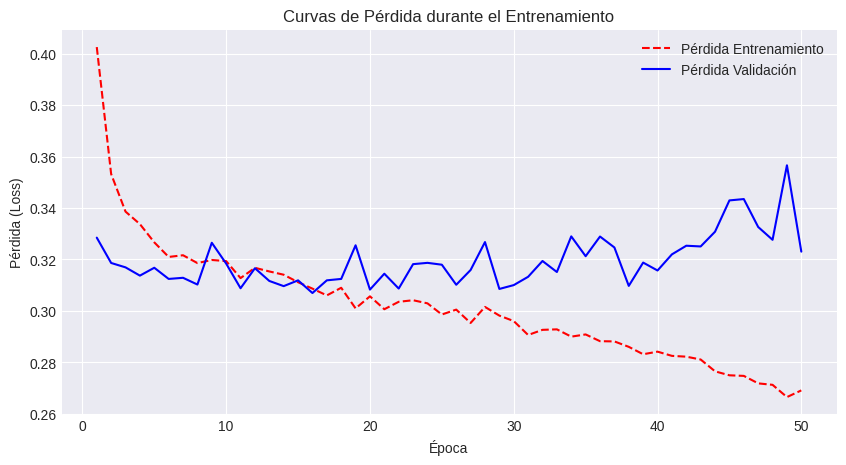

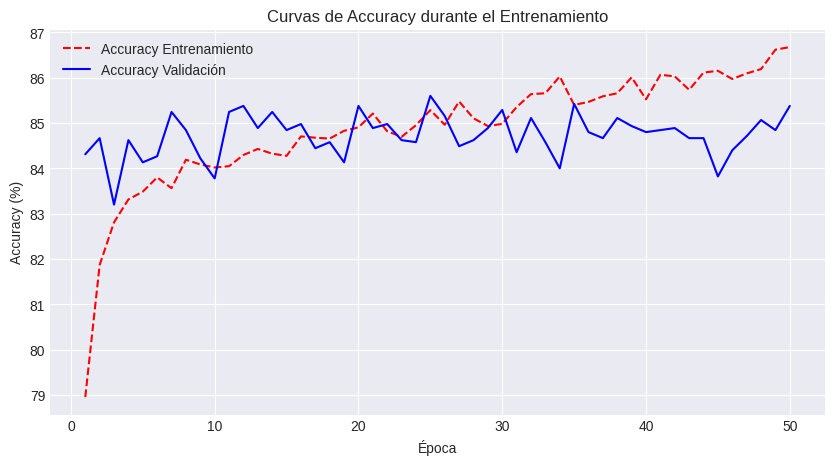

Gráficos generados.


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import math
from tqdm.notebook import tqdm # O from tqdm import tqdm
import os # Para guardar parámetros
import matplotlib.pyplot as plt # <--- IMPORTAR MATPLOTLIB

# --- Clases / Funciones que ASUMIMOS DEFINIDAS ANTERIORMENTE ---
# from data_generation_mod import generate_raw_maxcut_data, standardize_data # Funciones modificadas
# from model_mod import MaxCutAttentionModel # Modelo modificado con PE
# from MAXCUT import MaxCutInstance, MaxCutState, MaxCutEnvironment
# from Agents import ILS, FirstImprovementAgent, SingleAgentSolver, Perturbation
# -------------------------------------------------------------

# --- CONSTANTE ACTUALIZADA ---
FEATURE_DIM = 11 # <--- ¡NUEVA DIMENSIÓN!

# --- Configuración para generación de datos ---
NUM_SAMPLES_TOTAL = 15000
NUM_NODES_TRAIN = 30
DENSITY_TRAIN = 0.8
MIN_W_TRAIN = 10
MAX_W_TRAIN = 20

# --- Configuración ILS (sin cambios respecto a tu versión anterior) ---
ils_env_gen = MaxCutEnvironment
ils_ls_neighborhood = "flip"
ils_ls_max_actions = 1500
ils_ls_agent_gen = FirstImprovementAgent(neighborhood_type=ils_ls_neighborhood)
ils_ls_solver_gen = SingleAgentSolver(ils_env_gen, ils_ls_agent_gen, max_actions=ils_ls_max_actions)
ils_perturb_neighborhood = "flip"
ils_perturb_size = max(4, int(NUM_NODES_TRAIN * 0.20))
ils_perturb_gen = Perturbation(ils_env_gen, type=ils_perturb_neighborhood, pert_size=ils_perturb_size)
ils_max_iterations_gen = 150
ils_solver_generator = ILS(
    local_search=ils_ls_solver_gen,
    perturbation=ils_perturb_gen,
    max_iterations=ils_max_iterations_gen
)
print("Configuración de ILS para generación de datos (Mejorada):")
print(f"  - LS: FI con '{ils_ls_neighborhood}', max_actions={ils_ls_max_actions}")
print(f"  - Perturbación: '{ils_perturb_neighborhood}', pert_size={ils_perturb_size}")
print(f"  - ILS Iterations: {ils_max_iterations_gen}")

# --- Generación de Datos CRUDOS ---
print("Generando datos crudos (sin normalizar)...")
X_np_raw, Y_np = generate_raw_maxcut_data(
    num_samples=NUM_SAMPLES_TOTAL,
    num_nodes=NUM_NODES_TRAIN,
    ils_solver=ils_solver_generator,
    density=DENSITY_TRAIN,
    min_weight=MIN_W_TRAIN,
    max_weight=MAX_W_TRAIN,
    vertex_order_shuffle_seed=None,
)
if X_np_raw.shape[0] == 0:
    print("Error: No se generaron datos.")
    exit()
print(f"Datos crudos generados: X shape={X_np_raw.shape}")

# --- Normalización (Estandarización) ---
print("Aplicando estandarización Z-score...")
X_np_std, norm_params = standardize_data(X_np_raw)
norm_params_file = 'normalization_parameters.npz'
np.savez(norm_params_file, means=norm_params['means'], stds=norm_params['stds'])
print(f"Parámetros de normalización guardados en: {norm_params_file}")

# --- Convertir a tensores PyTorch ---
X_tensor = torch.tensor(X_np_std, dtype=torch.float32)
Y_tensor = torch.argmax(torch.tensor(Y_np, dtype=torch.float32), dim=1)
print(f"Datos listos para entrenamiento: X shape={X_tensor.shape}, Y shape={Y_tensor.shape}")

# --- División Train/Validation/Test ---
dataset = TensorDataset(X_tensor, Y_tensor)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f"Tamaños: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# --- DataLoaders ---
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Configuración del Entrenamiento ---
learning_rate = 3e-4
epochs = 50
criterion = nn.CrossEntropyLoss()

# --- Modelo (ASEGÚRATE QUE ESTÉ DEFINIDO E INSTANCIADO CORRECTAMENTE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- EJEMPLO de instanciación (DESCOMENTA Y AJUSTA) ---
# model = MaxCutAttentionModel(
#     input_dim=FEATURE_DIM, # FEATURE_DIM debe ser 11
#     embed_dim=128,
#     num_heads=8,
#     num_layers=4,
#     dim_feedforward=512,
#     dropout_rate=0.1,
#     max_seq_len=100 # Ajusta si N > 100
# ).to(device)
# print(f"Modelo instanciado con input_dim={model.input_dim}")
# --- ASEGÚRATE QUE EL forward() USA ÍNDICE 4 PARA IsDecision ---
# ----------------------------------------------------------------

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# --- Bucle de Entrenamiento y Validación ---
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\n--- Iniciando Entrenamiento ---")
for epoch in range(epochs):
    # Entrenamiento (código sin cambios)
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for i, data in enumerate(progress_bar_train):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        progress_bar_train.set_postfix({'loss': running_loss / total_train, 'acc': 100. * correct_train / total_train})
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validación (código sin cambios)
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for data in progress_bar_val:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            progress_bar_val.set_postfix({'val_loss': running_val_loss / total_val, 'val_acc': 100. * correct_val / total_val})
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = 100. * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{epochs} => "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

    # Guardar el mejor modelo (código sin cambios)
    model_save_path = 'best_maxcut_attention_model_v2.pth'
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"  => Modelo guardado en {model_save_path} (mejor val loss: {best_val_loss:.4f})")

print("\n--- Entrenamiento Finalizado ---")

# --- **NUEVO:** Graficar Curvas de Entrenamiento ---
print("Generando gráficos de entrenamiento...")
plt.style.use('seaborn-v0_8-darkgrid') # Estilo opcional

# Crear vector de épocas para el eje X
epoch_count = range(1, epochs + 1)

# Gráfico 1: Pérdida (Loss)
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_losses, 'r--', label='Pérdida Entrenamiento')
plt.plot(epoch_count, val_losses, 'b-', label='Pérdida Validación')
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida (Loss)')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.grid(True)
plt.show()

# Gráfico 2: Exactitud (Accuracy)
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_accs, 'r--', label='Accuracy Entrenamiento')
plt.plot(epoch_count, val_accs, 'b-', label='Accuracy Validación')
plt.legend()
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.title('Curvas de Accuracy durante el Entrenamiento')
plt.grid(True)
plt.show()

print("Gráficos generados.")
# ----------------------------------------------------

# Cargar el mejor modelo para evaluación (opcional, descomentar si se necesita)
# model.load_state_dict(torch.load(model_save_path))
# print(f"Mejor modelo cargado desde {model_save_path} para evaluación.")

In [7]:
class MaxCutModelEvalActions:
    def __init__(self, modele, num_nodes, normalization_params_path=None, device='cpu'): # path ahora es opcional
        self.model = modele
        self.model.eval()
        self.num_nodes = num_nodes
        self.feature_dim = FEATURE_DIM
        if hasattr(modele, 'input_dim') and modele.input_dim != self.feature_dim:
            print(f"Warning: Model input_dim ({modele.input_dim}) != FEATURE_DIM ({self.feature_dim})")
        self.device = device

        self.apply_standardization = False # Por defecto no aplicar
        if normalization_params_path: # Si se proporciona un path
            try:
                norm_data = np.load(normalization_params_path)
                self.feature_means = torch.tensor(norm_data['means'], dtype=torch.float32).to(self.device)
                self.feature_stds = torch.tensor(norm_data['stds'], dtype=torch.float32).to(self.device)
                self.apply_standardization = True # Activar solo si se cargan los params
                print(f"Parámetros de normalización cargados desde {normalization_params_path}. Se aplicará Z-score.")
            except FileNotFoundError:
                print(f"Warning: Archivo de parámetros de normalización no encontrado en {normalization_params_path}")
                print("El modelo procederá con datos CRUDOS (sin estandarización Z-score).")
        else:
            print("Warning: No se proporcionó path para parámetros de normalización.")
            print("El modelo procederá con datos CRUDOS (sin estandarización Z-score).")
            # Necesitamos definir feature_means y feature_stds igualmente para que el código no falle,
            # pero no se usarán si apply_standardization es False.
            # O, si se usaran, no tendrían efecto si son 0 y 1.
            self.feature_means = torch.zeros(self.feature_dim).to(self.device)
            self.feature_stds = torch.ones(self.feature_dim).to(self.device)


        self._cached_static_features = None
        self._cached_instance_hash = None

    def _get_or_compute_static_features(self, instance):
        current_hash = hash(instance.weights_matrix.tobytes())
        if current_hash != self._cached_instance_hash:
            degrees, sum_incident_weights, _ = calculate_static_features(instance)
            self._cached_static_features = (degrees, sum_incident_weights)
            self._cached_instance_hash = current_hash
        return self._cached_static_features

    def _state_to_raw_features(self, state, k_idx, static_degrees, static_sum_incident):
        instance = state.inst_info
        current_partition = state.partition
        n_nodes_actual = instance.num_nodes
        if self.num_nodes != n_nodes_actual:
             raise ValueError(f"Inconsistencia en num_nodes: evaluador espera {self.num_nodes}, instancia tiene {n_nodes_actual}")
        raw_feature_matrix = np.zeros((n_nodes_actual, self.feature_dim), dtype=np.float32)
        degrees = static_degrees
        sum_incident_weights = static_sum_incident
        for i_node in range(n_nodes_actual):
            sum_to_v1, sum_to_v2, sum_to_unassigned = calculate_dynamic_features(
                i_node, current_partition, instance
            )
            assign_state = current_partition[i_node]
            assign_is_unassigned = 1.0 if assign_state == -1 else 0.0
            assign_is_v2 = 1.0 if assign_state == 0 else 0.0
            assign_is_v1 = 1.0 if assign_state == 1 else 0.0
            is_decision_node = 1.0 if i_node == k_idx else 0.0
            local_cut_gain_v1 = sum_to_v2 - sum_to_v1
            raw_features = [
                float(i_node), assign_is_unassigned, assign_is_v2, assign_is_v1,
                is_decision_node, float(degrees[i_node]), sum_incident_weights[i_node],
                sum_to_v1, sum_to_v2, sum_to_unassigned, local_cut_gain_v1
            ]
            if len(raw_features) != self.feature_dim:
                raise ValueError(f"Feature vector length mismatch: expected {self.feature_dim}, got {len(raw_features)} for node {i_node}")
            raw_feature_matrix[i_node, :] = raw_features
        return raw_feature_matrix

    def __call__(self, state, env):
        if state.is_complete: return []
        try: k_idx = state.partition.index(-1)
        except ValueError: return []
        instance = state.inst_info
        static_degrees, static_sum_incident = self._get_or_compute_static_features(instance)
        raw_feature_matrix = self._state_to_raw_features(state, k_idx, static_degrees, static_sum_incident)

        X_tensor_for_model = torch.tensor(raw_feature_matrix, dtype=torch.float32).to(self.device)

        if self.apply_standardization: # Aplicar Z-score solo si los parámetros se cargaron
            X_tensor_for_model = (X_tensor_for_model - self.feature_means) / self.feature_stds

        X_input = X_tensor_for_model.unsqueeze(0)
        with torch.no_grad():
            logits = self.model(X_input)
            probabilities = F.softmax(logits, dim=1).squeeze(0)
        action_v1 = ("constructive", k_idx, 1)
        action_v2 = ("constructive", k_idx, 0)
        evals = [
            (action_v1, probabilities[0].item()),
            (action_v2, probabilities[1].item())
        ]
        return evals


--- Comparando Estrategias (Simplificado) ---
Probando tamaños: [10, 20, 30, 40, 50]
Instancias por tamaño: 30
Usando parámetros de normalización de: normalization_parameters.npz
Comparando: Heur-G, Mod-G, ILS
----------------------------------------------------

--- Evaluando tamaño N = 10 ---
Parámetros de normalización cargados desde normalization_parameters.npz. Se aplicará Z-score.


Instancias N=10:   0%|          | 0/30 [00:00<?, ?it/s]


--- Evaluando tamaño N = 20 ---
Parámetros de normalización cargados desde normalization_parameters.npz. Se aplicará Z-score.


Instancias N=20:   0%|          | 0/30 [00:00<?, ?it/s]


--- Evaluando tamaño N = 30 ---
Parámetros de normalización cargados desde normalization_parameters.npz. Se aplicará Z-score.


Instancias N=30:   0%|          | 0/30 [00:00<?, ?it/s]


--- Evaluando tamaño N = 40 ---
Parámetros de normalización cargados desde normalization_parameters.npz. Se aplicará Z-score.


Instancias N=40:   0%|          | 0/30 [00:00<?, ?it/s]


--- Evaluando tamaño N = 50 ---
Parámetros de normalización cargados desde normalization_parameters.npz. Se aplicará Z-score.


Instancias N=50:   0%|          | 0/30 [00:00<?, ?it/s]


--- Resultados Detallados (Primeras 5 Filas) ---
  instance_id  num_nodes  heur_g_cut  heur_g_time  model_g_cut  model_g_time     ils_cut  ils_time
0      N10-i1         10  153.709842     0.000967          0.0      0.024879  156.440437  0.017668
1      N10-i2         10  140.906429     0.000903          0.0      0.014696  140.906429  0.017780
2      N10-i3         10  150.657688     0.000948          0.0      0.014884  153.594216  0.015744
3      N10-i4         10  163.250499     0.000913          0.0      0.015634  167.370372  0.018281
4      N10-i5         10  153.437504     0.000926          0.0      0.014690  154.909147  0.018510

--- Resultados Promedio por Tamaño de Instancia ---
   num_nodes  heur_g_cut  heur_g_time  model_g_cut  model_g_time  ils_cut  ils_time
0         10      154.81         0.00         0.00          0.02   157.61      0.02
1         20      603.71         0.01       450.94          0.09   615.84      0.06
2         30     1330.58         0.03      1306.04 

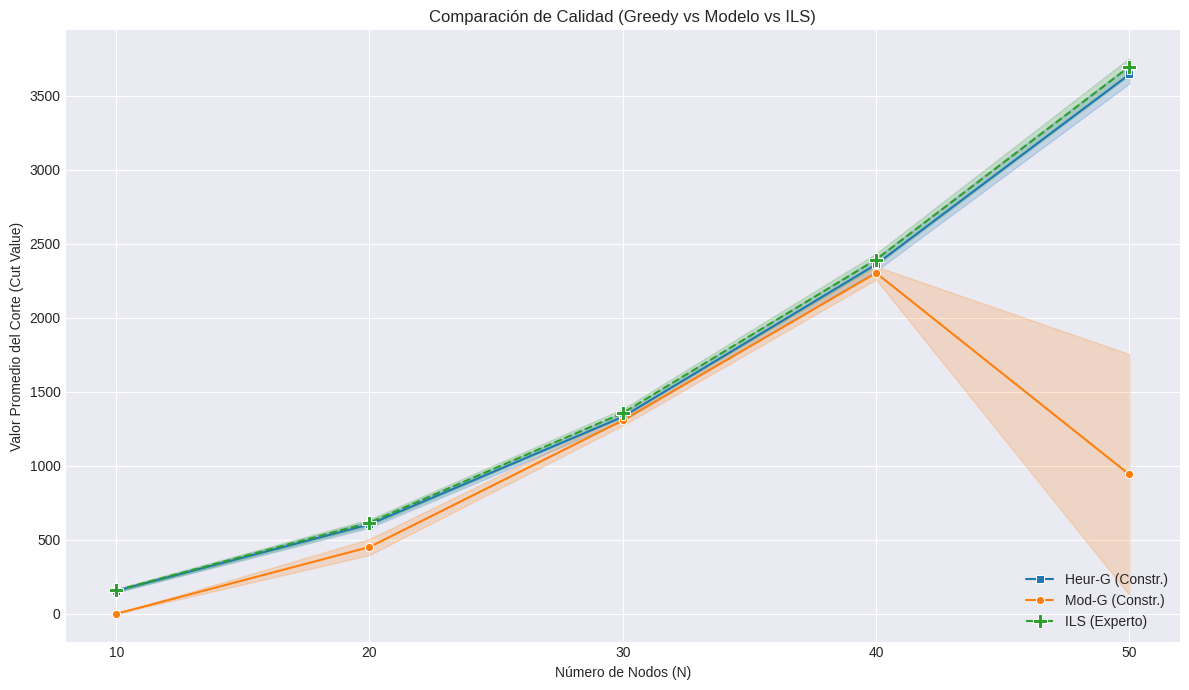

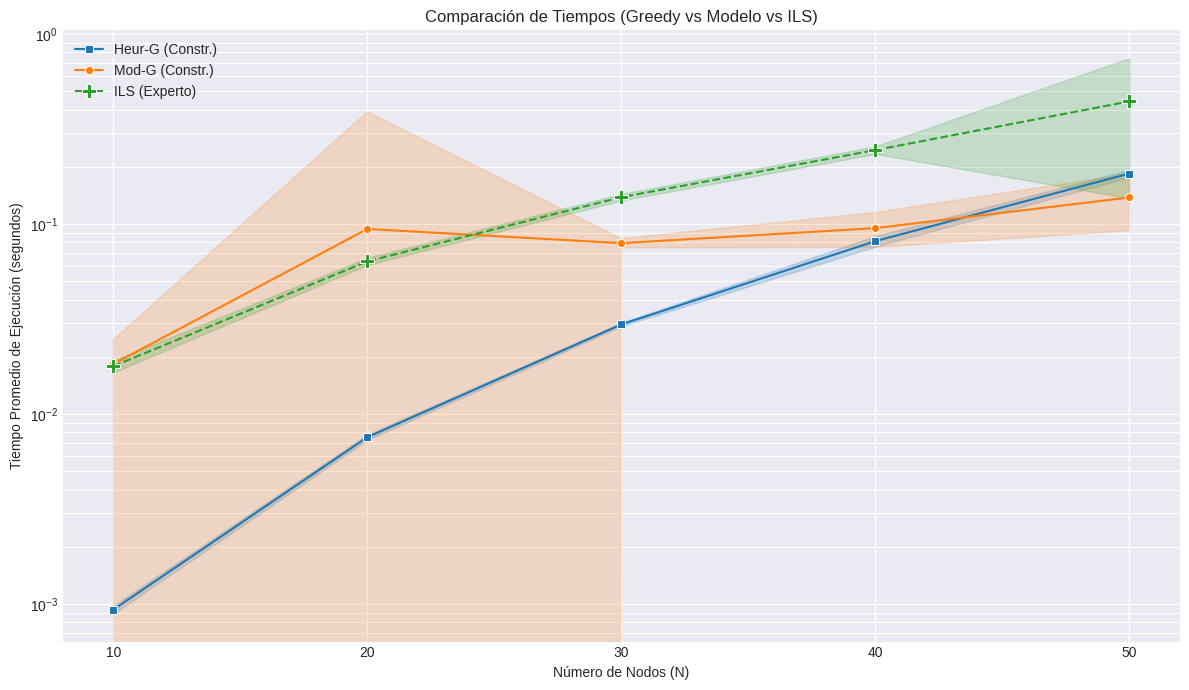

In [8]:
from Agents import GreedyAgent, evalConstructiveActions
from copy import deepcopy # Importar deepcopy
# Tus otros imports (GreedyAgent, evalConstructiveActions, StochasticAgent - aunque no se use ahora, etc.)
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- ASUMIMOS QUE ESTAS CLASES Y VARIABLES ESTÁN DEFINIDAS ---
# MaxCutEnvironment, MaxCutInstance, MaxCutState, generate_random_instance
# evalConstructiveActions, GreedyAgent, StochasticAgent, FirstImprovementAgent, SingleAgentSolver, ILS
# ils_solver_generator (configurado)
# model (modelo de PyTorch entrenado y cargado)
# device (torch.device)
# MaxCutModelEvalActions (tu clase evaluadora para el modelo)
# calculate_static_features, calculate_dynamic_features (si son necesarias para MaxCutModelEvalActions)
# ---------------------------------------------------------------

FEATURE_DIM = 11
NORM_PARAMS_PATH = 'normalization_parameters.npz'
DENSITY_TRAIN = 0.8 # Asegúrate que estos parámetros coincidan con algo representativo
MIN_W_TRAIN = 10
MAX_W_TRAIN = 20

env = MaxCutEnvironment()
INSTANCE_SIZES = [10, 20, 30, 40, 50]
NUM_TEST_INSTANCES_PER_SIZE = 30 # Puedes aumentar esto si quieres resultados más robustos
results_comparison = []

# --- Agentes y Solvers ---
agent_heuristic_greedy = GreedyAgent(evalConstructiveActions)
# Ya no necesitamos local_search_solver_for_refinement en esta versión simplificada

if not os.path.exists(NORM_PARAMS_PATH):
    print(f"ERROR: No se encontró el archivo de parámetros de normalización en {NORM_PARAMS_PATH}")
    exit()

print("\n--- Comparando Estrategias (Simplificado) ---")
print(f"Probando tamaños: {INSTANCE_SIZES}")
print(f"Instancias por tamaño: {NUM_TEST_INSTANCES_PER_SIZE}")
print(f"Usando parámetros de normalización de: {NORM_PARAMS_PATH}")
print("Comparando: Heur-G, Mod-G, ILS") # Estrategias actualizadas
print("----------------------------------------------------")

for n_nodes_test in INSTANCE_SIZES:
    print(f"\n--- Evaluando tamaño N = {n_nodes_test} ---")

    model_evaluator = MaxCutModelEvalActions(
        modele=model, num_nodes=n_nodes_test,
        normalization_params_path=NORM_PARAMS_PATH, device=device
    )
    agent_model_greedy = GreedyAgent(model_evaluator) # Modelo Determinista Greedy
    # agent_model_stochastic ya no se usa aquí

    for i in tqdm(range(NUM_TEST_INSTANCES_PER_SIZE), desc=f"Instancias N={n_nodes_test}", leave=False):
        weights_test = generate_random_instance(n_nodes_test, DENSITY_TRAIN, MIN_W_TRAIN, MAX_W_TRAIN)
        instance_test = MaxCutInstance(weights_test)
        instance_results = {'instance_id': f"N{n_nodes_test}-i{i+1}", 'num_nodes': n_nodes_test}

        # --- 1. Greedy Heurístico ---
        current_state_heur_g = MaxCutState(instance_test)
        start_time = time.time()
        try:
            # Usamos un SingleAgentSolver para encapsular el bucle constructivo
            solver_heur_g = SingleAgentSolver(env, agent_heuristic_greedy, max_actions=n_nodes_test + 5) # max_actions = N es suficiente
            solution_heur_g = solver_heur_g.solve(current_state_heur_g)
            instance_results['heur_g_cut'] = solution_heur_g.cut_value
        except Exception as e: print(f"Err Heur-G ({instance_results['instance_id']}): {e}"); instance_results['heur_g_cut'] = -1
        instance_results['heur_g_time'] = time.time() - start_time

        # --- 2. Modelo Greedy (Determinista) ---
        current_state_model_g = MaxCutState(instance_test)
        start_time = time.time()
        try:
            solver_model_g = SingleAgentSolver(env, agent_model_greedy, max_actions=n_nodes_test + 5)
            solution_model_g = solver_model_g.solve(current_state_model_g)
            instance_results['model_g_cut'] = solution_model_g.cut_value
        except Exception as e: print(f"Err Mod-G ({instance_results['instance_id']}): {e}"); instance_results['model_g_cut'] = -1
        instance_results['model_g_time'] = time.time() - start_time

        # --- 3. ILS (Benchmark Experto) ---
        # (Mantenido para referencia, puedes comentarlo si quieres una comparación estrictamente de los dos primeros)
        initial_partition_ils = [random.choice([0, 1]) for _ in range(n_nodes_test)]
        initial_state_ils = MaxCutState(instance_test, partition=initial_partition_ils)
        start_time = time.time()
        try:
            final_state_ils = ils_solver_generator.solve(initial_state_ils)
            instance_results['ils_cut'] = final_state_ils.cut_value
        except Exception as e: print(f"Err ILS ({instance_results['instance_id']}): {e}"); instance_results['ils_cut'] = -1
        instance_results['ils_time'] = time.time() - start_time

        results_comparison.append(instance_results)

# --- Procesar y Mostrar Resultados ---
if results_comparison:
    comparison_df = pd.DataFrame(results_comparison)
    comparison_df.replace(-1, np.nan, inplace=True) # Reemplazar errores con NaN para que mean() los ignore

    print("\n--- Resultados Detallados (Primeras 5 Filas) ---")
    print(comparison_df.head().to_string())

    print("\n--- Resultados Promedio por Tamaño de Instancia ---")
    numeric_cols = comparison_df.select_dtypes(include=np.number).columns
    cols_to_average = [col for col in numeric_cols if col != 'num_nodes']
    avg_results = comparison_df.groupby('num_nodes')[cols_to_average].mean()
    avg_results_to_print = avg_results.reset_index()

    cols_order = ['num_nodes',
                  'heur_g_cut', 'heur_g_time',
                  'model_g_cut', 'model_g_time',
                  'ils_cut', 'ils_time'] # Columnas actualizadas

    cols_to_print = [col for col in cols_order if col in avg_results_to_print.columns]
    print(avg_results_to_print[cols_to_print].to_string(float_format="%.2f"))

    # --- Graficación ---
    print("\n--- Generando Gráficos ---")
    plt.style.use('seaborn-v0_8-darkgrid')
    instance_sizes_plot = sorted(comparison_df['num_nodes'].unique())

    # 1. Gráfico de Calidad (Cut Value)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=comparison_df, x='num_nodes', y='heur_g_cut', label='Heur-G (Constr.)', marker='s', errorbar='sd')
    sns.lineplot(data=comparison_df, x='num_nodes', y='model_g_cut', label='Mod-G (Constr.)', marker='o', errorbar='sd')
    sns.lineplot(data=comparison_df, x='num_nodes', y='ils_cut', label='ILS (Experto)', marker='P', markersize=10, linestyle='--', errorbar='sd')

    plt.xlabel("Número de Nodos (N)")
    plt.ylabel("Valor Promedio del Corte (Cut Value)")
    plt.title("Comparación de Calidad (Greedy vs Modelo vs ILS)")
    plt.xticks(instance_sizes_plot)
    plt.legend(loc='lower right')
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()

    # 2. Gráfico de Tiempo de Ejecución
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=comparison_df, x='num_nodes', y='heur_g_time', label='Heur-G (Constr.)', marker='s', errorbar='sd')
    sns.lineplot(data=comparison_df, x='num_nodes', y='model_g_time', label='Mod-G (Constr.)', marker='o', errorbar='sd')
    sns.lineplot(data=comparison_df, x='num_nodes', y='ils_time', label='ILS (Experto)', marker='P', markersize=10, linestyle='--', errorbar='sd')

    plt.xlabel("Número de Nodos (N)")
    plt.ylabel("Tiempo Promedio de Ejecución (segundos)")
    plt.title("Comparación de Tiempos (Greedy vs Modelo vs ILS)")
    plt.xticks(instance_sizes_plot)
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.grid(True, which="both", ls="-")
    plt.tight_layout()
    plt.show()
else:
    print("No se generaron resultados para mostrar.")